# Computing and plotting monthly climatologies

Quick example of how to compute monthly climatologies of catalogued data and generate Hovmöller plots with the resulting averages. First, we start up a Kubernetes cluster and client:

In [4]:
from dask_kubernetes import KubeCluster

cluster = KubeCluster(n_workers=10)
cluster

In [5]:
from dask.distributed import Client

client = Client(cluster)
client

Client Scheduler: tcp://10.51.81.21:44993 Dashboard: /user/charlesbluca-pa-racmip-examples-8vouul33/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


Then we open up the preexisting catalog of TRACMIP data:

In [2]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-bot/pangeo-datastore/master/master.yaml").search("tracmip") \
                                                                                                      .search("Amon") \
                                                                                                      .search("aquaControl") \
                                                                                                      .search(".pr.")
cat

<Intake catalog: master_search_search_search_search>

Create our dataframe and view it with `qgrid` widget:

In [3]:
from pandas import DataFrame
from qgrid import show_grid

df = DataFrame({"frequency"  : [item.split(".")[1] for item in list(cat)],
                "experiment" : [item.split(".")[2] for item in list(cat)],
                "model"      : [item.split(".")[3] for item in list(cat)],
                "variable"   : [item.split(".")[4] for item in list(cat)],
                "version"    : [item.split(".")[5] for item in list(cat)],
                "source"     : [cat[item] for item in list(cat)]})

qg = show_grid(df)
qg

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

After selecting our desired data using the widget, pull it in:

In [4]:
sources = [item.to_dask() for item in qg.get_changed_df()["source"]]
len(sources)

14

Finally, we make a rough Hovmöller plot of this data, using `xarray`'s `groupby` method to produce monthly means:

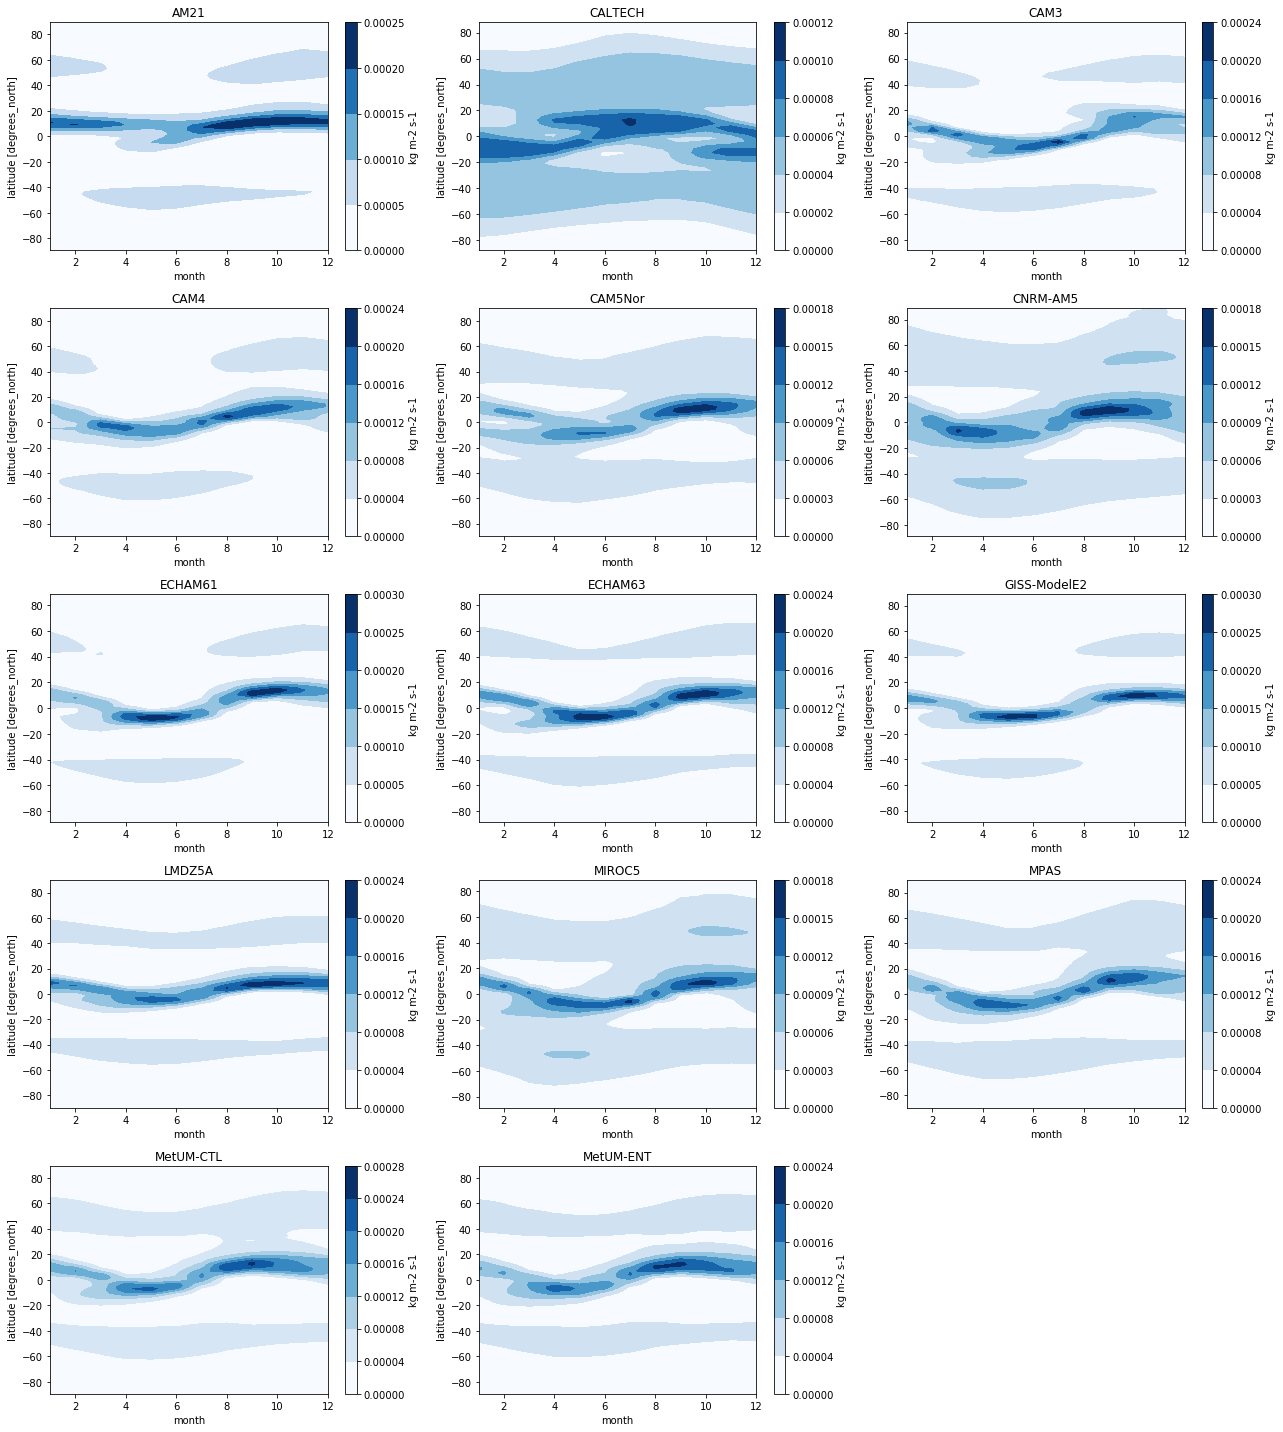

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(18, 20), facecolor='w', edgecolor='k')

for i, source in enumerate(sources):
    ax = plt.subplot(5, 3, i + 1)
    source["pr"].groupby("time.month").mean(dim=("time", "lon")) \
                .plot.contourf(x="month", 
                               cmap="Blues", 
                               cbar_kwargs={"label" : source["pr"].attrs["units"]})
    ax.set(title=source.attrs["model_id"])
    
plt.tight_layout()